In [1]:
import warnings
warnings.simplefilter('ignore')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from fast_ml.feature_selection import get_constant_features

from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import PowerTransformer, StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
import scipy.stats as stats
from sklearn.model_selection import train_test_split, cross_val_score, KFold, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import pickle
import os
from sklearn.ensemble import RandomForestRegressor
import lightgbm
import statsmodels.api as sm

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import keras_tuner as kt
from keras.regularizers import l2



%matplotlib inline

In [7]:
Xtrain = pd.read_csv('transformed_data/Xtrain_transformed.csv')
ytrain = pd.read_csv('transformed_data/ytrain.csv')

Xtest = pd.read_csv('transformed_data/Xtest_transformed.csv')
ytest = pd.read_csv('transformed_data/ytest.csv')

In [9]:
def build_model(hyperparameter):
    model = Sequential()
    counter = 0
    
    for i in range(hyperparameter.Int('num_layers',min_value = 1, max_value = 10)):
        if i == 0:
            model.add(Dense(
                hyperparameter.Int('units' + str(i), min_value = 8, max_value = 256, step = 8),
                hyperparameter.Choice('activation' + str(i), values = ['relu', 'selu', 'tanh', 'sigmoid']),
                kernel_initializer = 'he_uniform', kernel_regularizer = l2(0.001),
                input_dim = Xtrain.shape[1]
            ))
            counter += 1
        else:
            model.add(Dense(
                hyperparameter.Int('units' + str(i), min_value = 8, max_value = 256, step = 8),
                hyperparameter.Choice('activation' + str(i), values = ['relu', 'selu', 'tanh', 'sigmoid']),
                kernel_initializer = 'he_uniform', kernel_regularizer = l2(0.001)
            ))
            model.add(Dropout(hyperparameter.Choice('dropout' + str(i), values=[0.1,0.2,0.3,0.4,0.5,0.6])))
            model.add(BatchNormalization())
            
    model.add(Dense(1, activation='linear'))
    model.compile(hyperparameter.Choice(
        'optimizer', values = ['adam', 'rmsprop', 'sgd', 'adadelta', 'adagrad']), 
                  loss='mean_squared_error', metrics=['mse']
                  )
    return model

In [28]:
tuner = kt.RandomSearch(hypermodel = build_model, max_trials = 5, objective = ['val_mse'], 
                     directory = 'DNN_RandomSearch_Tuner', project_name = 'trial_03')

In [29]:
tuner.search(Xtrain, ytrain, epochs = 5, validation_data = (Xtest, ytest), validation_split = 0.3)

Trial 5 Complete [00h 01m 33s]
multi_objective: nan

Best multi_objective So Far: 17405896704.0
Total elapsed time: 00h 11m 08s


In [30]:
tuned_model = tuner.get_best_models()[0]
tuned_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 224)               2912      
                                                                 
 dense_1 (Dense)             (None, 208)               46800     
                                                                 
 dropout (Dropout)           (None, 208)               0         
                                                                 
 batch_normalization (BatchN  (None, 208)              832       
 ormalization)                                                   
                                                                 
 dense_2 (Dense)             (None, 224)               46816     
                                                                 
 dropout_1 (Dropout)         (None, 224)               0         
                                                        

In [31]:
early_stopping = EarlyStopping(
    monitor='val_mse',
    min_delta=0.003,
    patience=5,
    verbose=1,
    mode='auto',
    baseline=None,
    restore_best_weights=True
)

model_checkpoint = ModelCheckpoint(
    'dnn_tuned.h5',
    monitor='val_mse',
    mode='auto',
    verbose=1,
    save_best_only=True
)

In [32]:
history = tuned_model.fit(Xtrain, ytrain, batch_size=32, epochs=50, 
                    validation_data=(Xtest, ytest),
                    validation_split=0.2,
                    callbacks=[early_stopping, model_checkpoint])

Epoch 1/50
2233/2235 [============================>.] - ETA: 0s - loss: 17905082368.0000 - mse: 17905082368.0000
Epoch 1: val_mse improved from inf to 17405310976.00000, saving model to dnn_tuned.h5
2235/2235 [==============================] - 31s 14ms/step - loss: 17903097856.0000 - mse: 17903097856.0000 - val_loss: 17405310976.0000 - val_mse: 17405310976.0000
Epoch 2/50
2233/2235 [============================>.] - ETA: 0s - loss: 17904781312.0000 - mse: 17904781312.0000
Epoch 2: val_mse improved from 17405310976.00000 to 17404547072.00000, saving model to dnn_tuned.h5
2235/2235 [==============================] - 30s 13ms/step - loss: 17902661632.0000 - mse: 17902661632.0000 - val_loss: 17404547072.0000 - val_mse: 17404547072.0000
Epoch 3/50
2233/2235 [============================>.] - ETA: 0s - loss: 17897119744.0000 - mse: 17897119744.0000
Epoch 3: val_mse improved from 17404547072.00000 to 17403719680.00000, saving model to dnn_tuned.h5
2235/2235 [==============================] - 

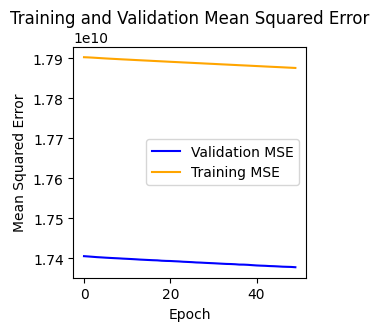

In [33]:
plt.figure(figsize=(3,3))

plt.plot(history.history['val_mse'], color='blue', label='Validation MSE')
plt.plot(history.history['mse'], color='orange', label='Training MSE')

plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.title('Training and Validation Mean Squared Error')

plt.legend()

plt.show()

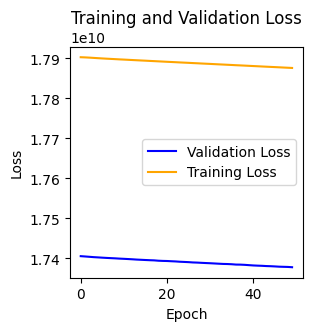

In [34]:
plt.figure(figsize=(3,3))

plt.plot(history.history['val_loss'], color='blue', label='Validation Loss')
plt.plot(history.history['loss'], color='orange', label='Training Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')

plt.legend()

plt.show()

In [35]:
history.history.keys()

dict_keys(['loss', 'mse', 'val_loss', 'val_mse'])

In [36]:
y_pred = tuned_model.predict(Xtest)

r2_score_dnn_tuned = r2_score(ytest, y_pred)
print('R2 Score:', r2_score_dnn_tuned)

559/559 [==============================] - 2s 3ms/step
R2 Score: -1.1716981337871362
